In [45]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [46]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [47]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


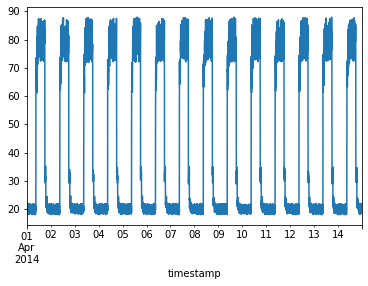

In [4]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

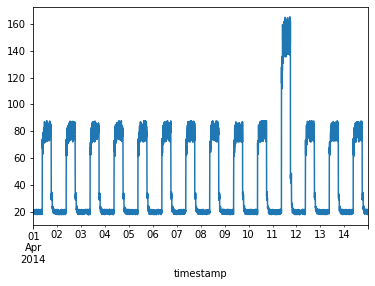

In [5]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

In [6]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [48]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)
x_train = x_train[:,:,0]
print(x_train.shape)

Training input shape:  (3745, 288, 1)
(3745, 288)


In [53]:
# model = keras.Sequential(
#     [
#         layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
#         layers.Conv1D(
#             filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
#         ),
#         layers.Dropout(rate=0.2),
#         layers.Conv1D(
#             filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
#         ),
#         layers.Conv1DTranspose(
#             filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
#         ),
#         layers.Dropout(rate=0.2),
#         layers.Conv1DTranspose(
#             filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
#         ),
#         layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
#     ]
# )
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1])),
        layers.Dense(20, activation='relu'),
        layers.Dense(x_train.shape[1], activation='linear')
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mse")
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 20)                5780      
_________________________________________________________________
dense_13 (Dense)             (None, 288)               6048      
Total params: 11,828
Trainable params: 11,828
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = model.fit(
    x_train,
    x_train,
    epochs=10000,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, mode="min", restore_best_weights=True)
    ],
)

Epoch 1/10000
27/27 [==============================] - 0s 4ms/step - loss: 0.3964 - val_loss: 0.1370
Epoch 2/10000
27/27 [==============================] - 0s 2ms/step - loss: 0.1069 - val_loss: 0.0790
Epoch 3/10000
27/27 [==============================] - 0s 1ms/step - loss: 0.0734 - val_loss: 0.0665
Epoch 4/10000
27/27 [==============================] - 0s 2ms/step - loss: 0.0652 - val_loss: 0.0611
Epoch 5/10000
27/27 [==============================] - 0s 2ms/step - loss: 0.0588 - val_loss: 0.0543
Epoch 6/10000
27/27 [==============================] - 0s 1ms/step - loss: 0.0531 - val_loss: 0.0492
Epoch 7/10000
27/27 [==============================] - 0s 1ms/step - loss: 0.0489 - val_loss: 0.0468
Epoch 8/10000
27/27 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0447
Epoch 9/10000
27/27 [==============================] - 0s 1ms/step - loss: 0.0450 - val_loss: 0.0433
Epoch 10/10000
27/27 [==============================] - 0s 1ms/step - loss: 0.0440 - val_lo

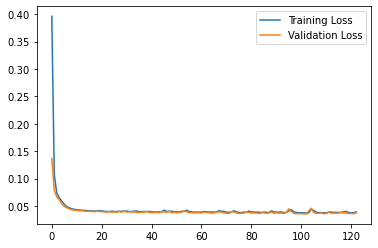

In [55]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

(3745, 288)
(3745,)


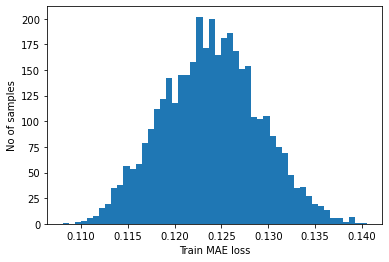

Reconstruction error threshold:  0.1405082328849232


In [57]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
print(x_train_pred.shape)

train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
print(train_mae_loss.shape)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

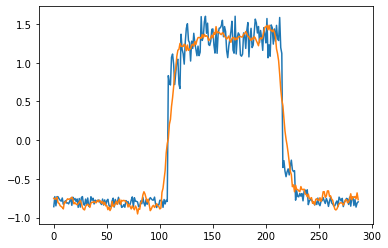

In [58]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

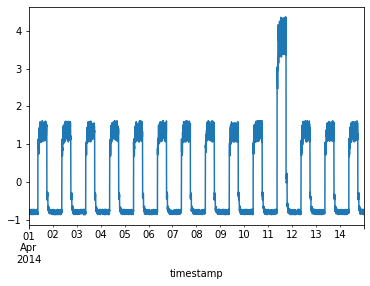

Test input shape:  (3745, 288, 1)


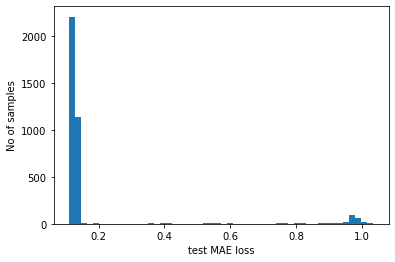

Number of anomaly samples:  400
Indices of anomaly samples:  (array([1325, 1326, 1381, 1613, 1614, 1668, 1981, 2703, 2704, 2705, 2706,
       2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717,
       2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728,
       2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739,
       2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750,
       2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761,
       2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772,
       2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783,
       2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794,
       2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805,
       2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816,
       2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827,
       2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2

In [59]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std

fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)
x_test = x_test[:,:,0]

# Get test MAE loss.
x_test_pred = model.predict(x_test)

test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [43]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [60]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
df_subset

,value
timestamp,
2014-04-11 09:10:00,122.386410
2014-04-11 09:15:00,127.261178
2014-04-11 09:20:00,121.157997
2014-04-11 09:25:00,120.468468
2014-04-11 09:30:00,111.624775
...,...
2014-04-11 17:35:00,151.380135
2014-04-11 17:40:00,156.009099
2014-04-11 17:45:00,164.947481


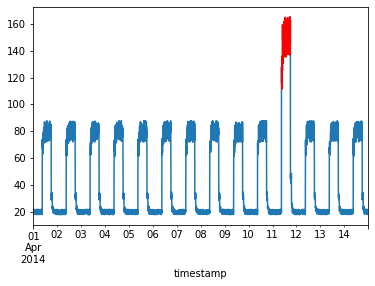

In [61]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()